In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import colorcet as cc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [2]:
chicago_data = pd.read_csv('ijzp-q8t2.csv')
print(chicago_data.head())
# Basic data preprocessing
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Hour'] = data['Date'].dt.hour
    data = data.dropna(subset=['latitude', 'longitude', 'primary_type'])
    return data
chicago_data = preprocess_data(chicago_data)

         id case_number                     date             block  iucr  \
0  13492557    JH302658  2024-06-11T08:00:00.000   018XX S TROY ST  0560   
1  13489958    JH299648  2024-06-09T00:00:00.000   034XX E 89TH ST  501A   
2  13489695    JH299359  2024-06-09T00:00:00.000  100XX S AVENUE M  4387   
3  13492799    JH303164  2024-06-09T00:00:00.000   002XX E 32ND ST  1242   
4  13489311    JH298954  2024-06-09T00:00:00.000  004XX W BRIAR PL  0920   

          primary_type                  description location_description  \
0              ASSAULT                       SIMPLE            RESIDENCE   
1        OTHER OFFENSE       ANIMAL ABUSE / NEGLECT        PARK PROPERTY   
2        OTHER OFFENSE  VIOLATE ORDER OF PROTECTION            RESIDENCE   
3   DECEPTIVE PRACTICE               COMPUTER FRAUD            APARTMENT   
4  MOTOR VEHICLE THEFT         ATTEMPT - AUTOMOBILE               STREET   

   arrest  domestic  ...  ward  community_area  fbi_code  x_coordinate  \
0   False   

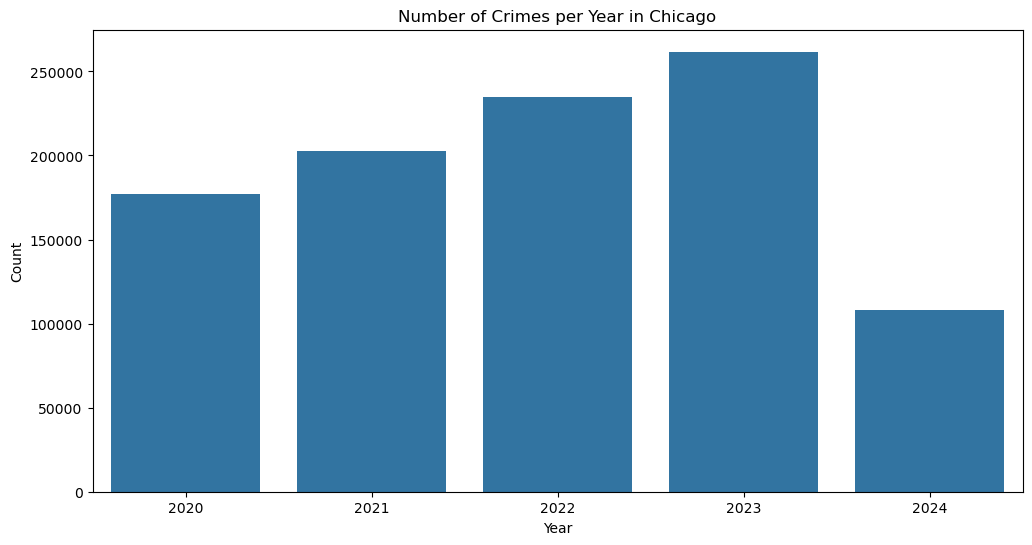

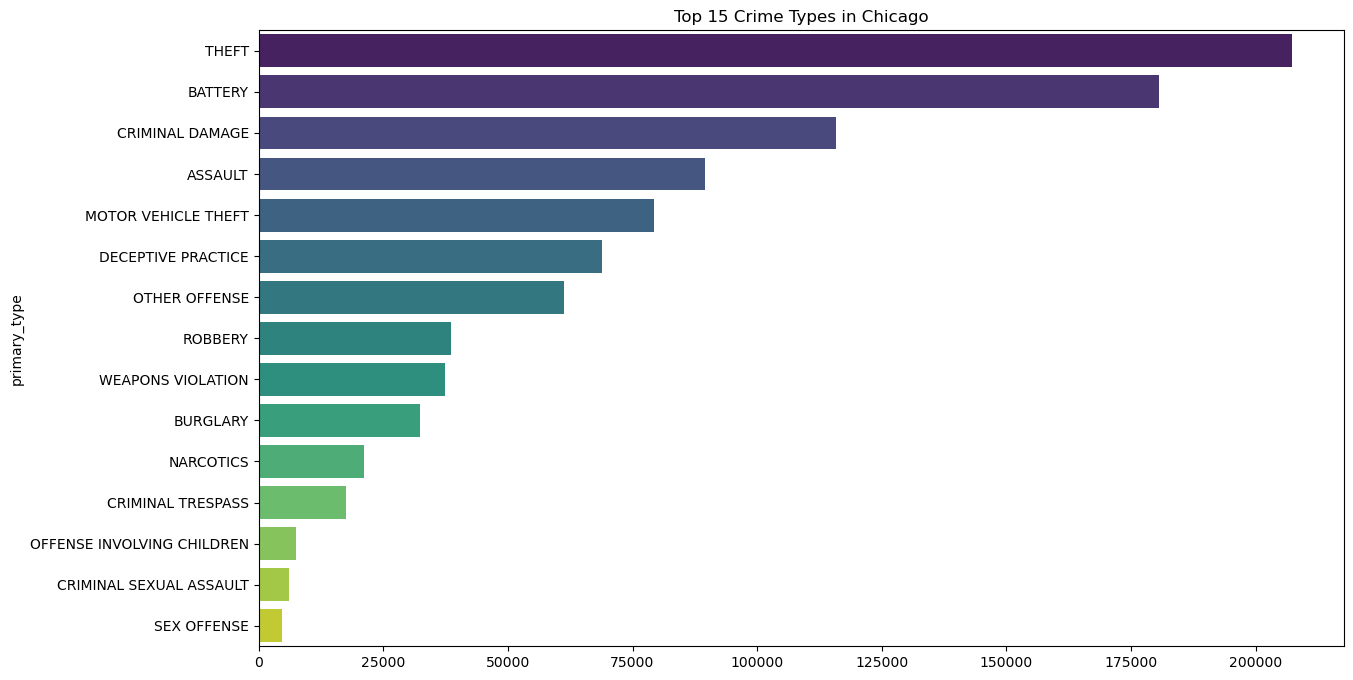

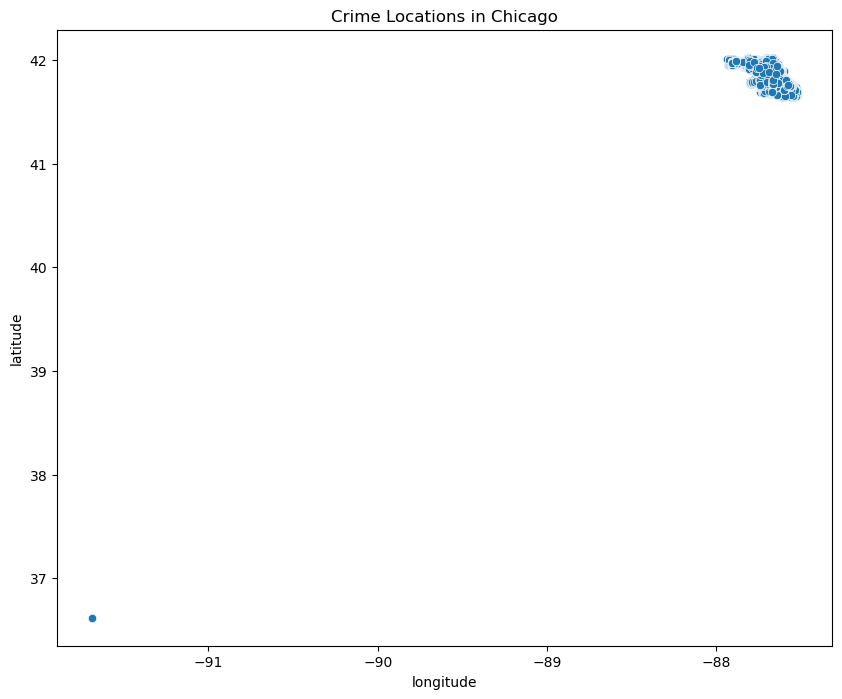

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
# Check if 'Year' column exists and create it if not
if 'Year' not in chicago_data.columns:
    chicago_data['Year'] = pd.to_datetime(chicago_data['date']).dt.year

# Plot the number of crimes per year
plt.figure(figsize=(12, 6))
sns.countplot(data=chicago_data, x='Year')
plt.title('Number of Crimes per Year in Chicago')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Top 15 crime types
plt.figure(figsize=(14, 8))
top_crimes = chicago_data['primary_type'].value_counts().head(15)
sns.barplot(y=top_crimes.index, x=top_crimes.values, palette='viridis')
plt.title('Top 15 Crime Types in Chicago')
plt.show()

# Crime density by location
plt.figure(figsize=(10, 8))
sns.scatterplot(data=chicago_data, x='longitude', y='latitude', palette='viridis')
plt.title('Crime Locations in Chicago')
plt.legend([], frameon=False)
plt.show()


In [4]:
# Step 3: Model Development
# Feature and target preparation
X = chicago_data[['Month', 'Day', 'Hour', 'longitude', 'latitude']]
y = chicago_data['primary_type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Handling classes with few samples
min_samples_per_class = 10
class_counts = pd.Series(y_encoded).value_counts()
valid_classes = class_counts[class_counts >= min_samples_per_class].index
filtered_data = chicago_data[chicago_data['primary_type'].apply(lambda x: le.transform([x])[0] in valid_classes)]

X_filtered = filtered_data[['Month', 'Day', 'Hour', 'longitude', 'latitude']]
y_filtered = le.transform(filtered_data['primary_type'])

# Re-encode y_filtered to ensure contiguous classes starting from 0
label_mapping = {original: i for i, original in enumerate(np.unique(y_filtered))}
y_contiguous = np.array([label_mapping[label] for label in y_filtered])

# Feature scaling
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_filtered_scaled, y_contiguous, test_size=0.3, random_state=42, stratify=y_contiguous)

KNN Classification Report:

                                   precision    recall  f1-score   support

                            ARSON       0.02      0.03      0.02       664
                          ASSAULT       0.10      0.20      0.14     26871
                          BATTERY       0.21      0.33      0.25     54189
                         BURGLARY       0.09      0.06      0.07      9701
CONCEALED CARRY LICENSE VIOLATION       0.03      0.02      0.02       225
              CRIM SEXUAL ASSAULT       0.14      0.13      0.14     34737
                  CRIMINAL DAMAGE       0.04      0.01      0.01      1813
          CRIMINAL SEXUAL ASSAULT       0.05      0.01      0.02      5284
                CRIMINAL TRESPASS       0.16      0.12      0.14     20642
               DECEPTIVE PRACTICE       0.00      0.00      0.00        20
                         GAMBLING       0.01      0.00      0.00       935
                         HOMICIDE       0.00      0.00      0.00       

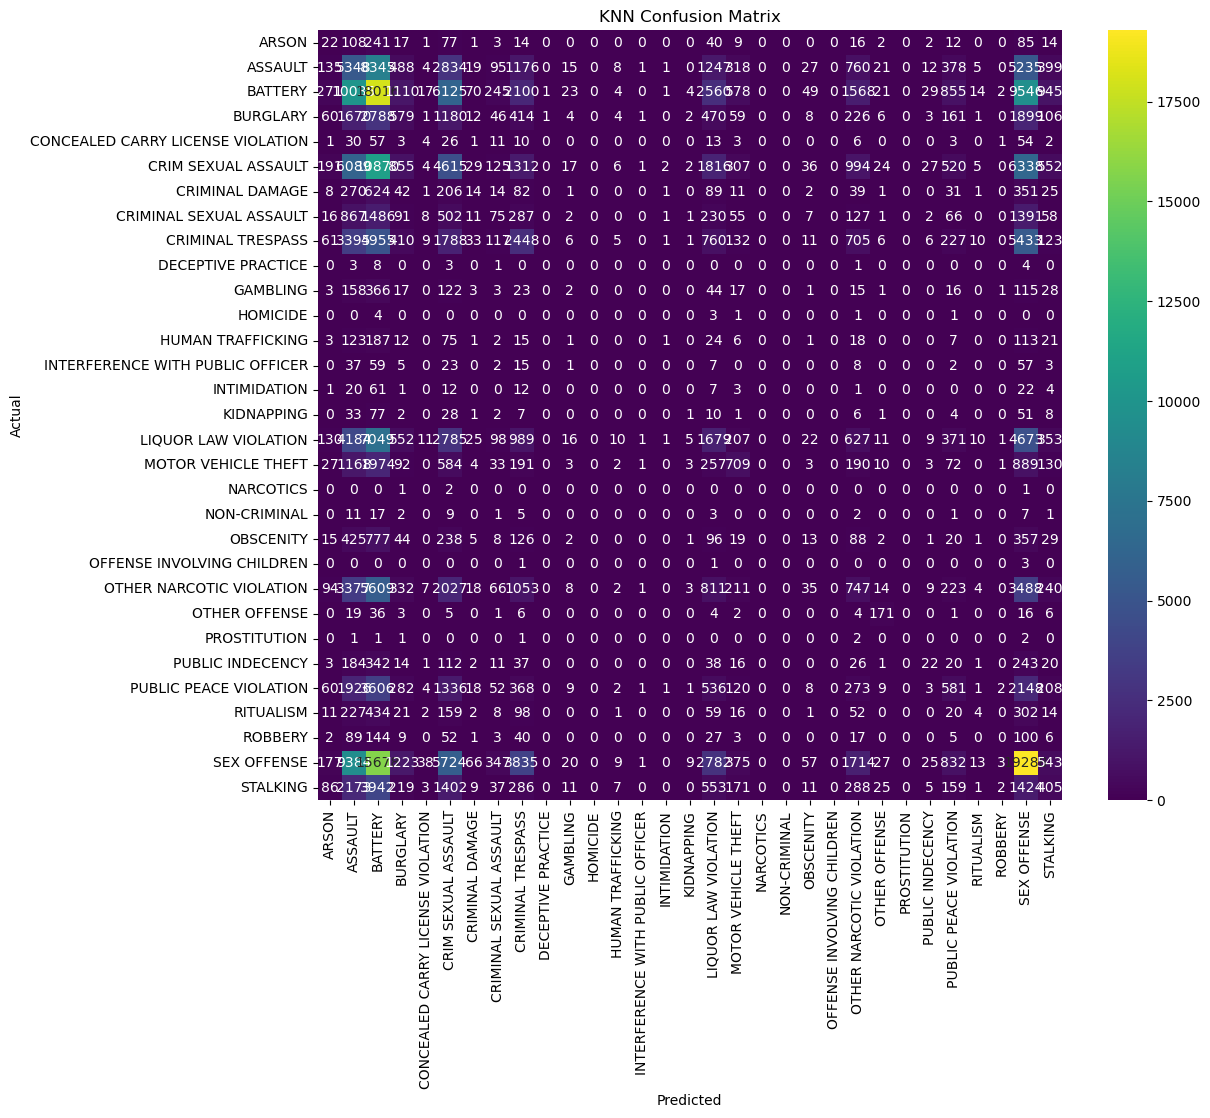

In [5]:
# Train KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_knn = knn_model.predict(X_test)

# Classification report
print("KNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn, target_names=le.inverse_transform(np.unique(y_test))))

# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.inverse_transform(np.unique(y_test)), yticklabels=le.inverse_transform(np.unique(y_test)))
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

      Iter       Train Loss   Remaining Time 
         1           2.4010           80.99m
         2           2.3781           78.09m
         3 169175743432290604082001048714546235407689010443995031178839464075067392.0000           75.83m
         4 169175743432290604082001048714546235407689010443995031178839464075067392.0000           74.28m
         5 1832303730100624971020347421892300015434902112565537231165045895270823710078134853191358482170283691866014028225458767331852288.0000           73.05m
         6 1832303730100624971020347421892300015434902112565537231165045895270823710078134853191358482170283691866014028225458767331852288.0000           73.20m
         7 1832303730100624971020347421892300015434902112565537231165045895270823710078134853191358482170283691866014028225458767331852288.0000           72.07m
         8 1832303730100624971020347421892300015434902112565537231165045895270823710078134853191358482170283691866014028225458767331852288.0000           70.97m
        

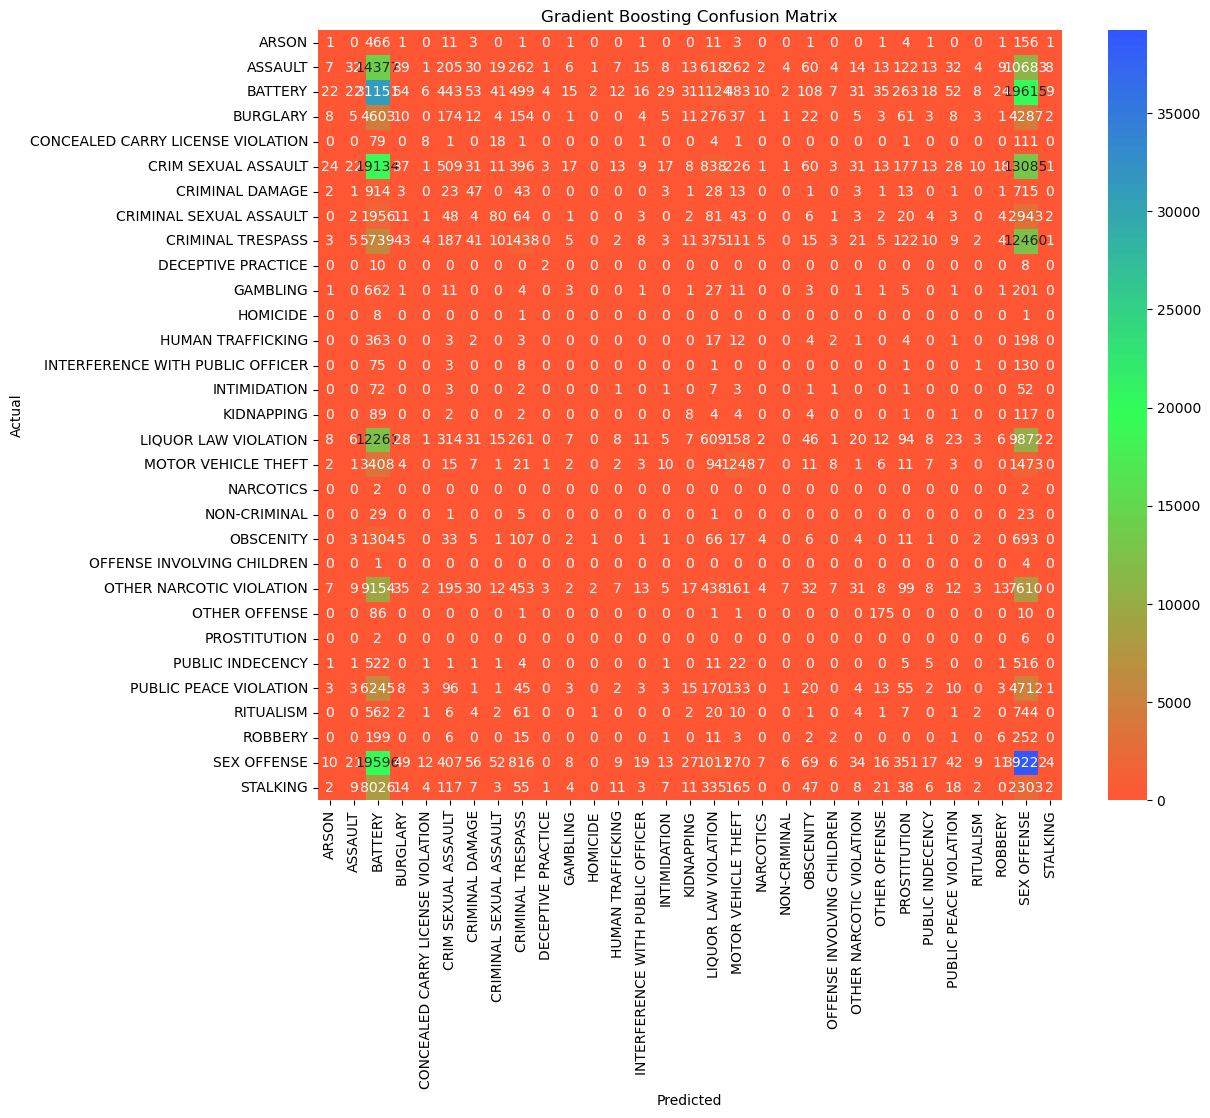

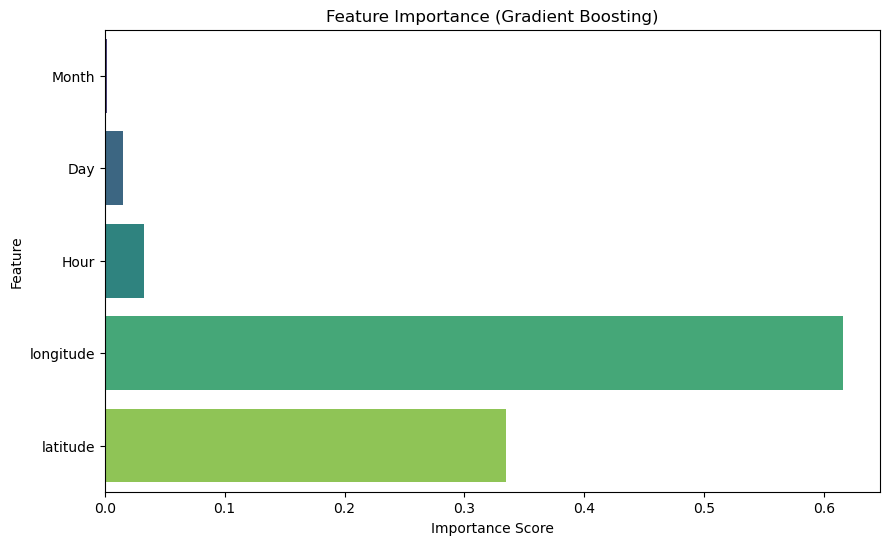

In [9]:
# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=True)
gb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_gb = gb_model.predict(X_test)

# Classification report
print("Gradient Boosting Classification Report:\n")
print(classification_report(y_test, y_pred_gb, target_names=le.inverse_transform(np.unique(y_test))))

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(12, 10))

# Define a custom colormap
colors = ["#FF5733", "#33FF57", "#3357FF"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

# Plot the heatmap with the custom colormap
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=le.inverse_transform(np.unique(y_test)), 
            yticklabels=le.inverse_transform(np.unique(y_test)))
plt.title("Heatmap with Custom LinearSegmentedColormap")
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_model.feature_importances_, y=X.columns, palette='viridis')
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Iteration 1, loss = 2.33645220
Iteration 2, loss = 2.30252254
Iteration 3, loss = 2.29624440
Iteration 4, loss = 2.29297589
Iteration 5, loss = 2.29055256
Iteration 6, loss = 2.28828369
Iteration 7, loss = 2.28661865
Iteration 8, loss = 2.28531489
Iteration 9, loss = 2.28410705
Iteration 10, loss = 2.28290584
Iteration 11, loss = 2.28185357
Iteration 12, loss = 2.28092440
Iteration 13, loss = 2.28011220
Iteration 14, loss = 2.27950426
Iteration 15, loss = 2.27881288
Iteration 16, loss = 2.27837284
Iteration 17, loss = 2.27809657
Iteration 18, loss = 2.27743129
Iteration 19, loss = 2.27693787
Iteration 20, loss = 2.27654874
Iteration 21, loss = 2.27612321
Iteration 22, loss = 2.27602457
Iteration 23, loss = 2.27569375
Iteration 24, loss = 2.27538340
Iteration 25, loss = 2.27499294
Iteration 26, loss = 2.27478304
Iteration 27, loss = 2.27445493
Iteration 28, loss = 2.27429136
Iteration 29, loss = 2.27412167
Iteration 30, loss = 2.27385999
Iteration 31, loss = 2.27363049
Iteration 32, los

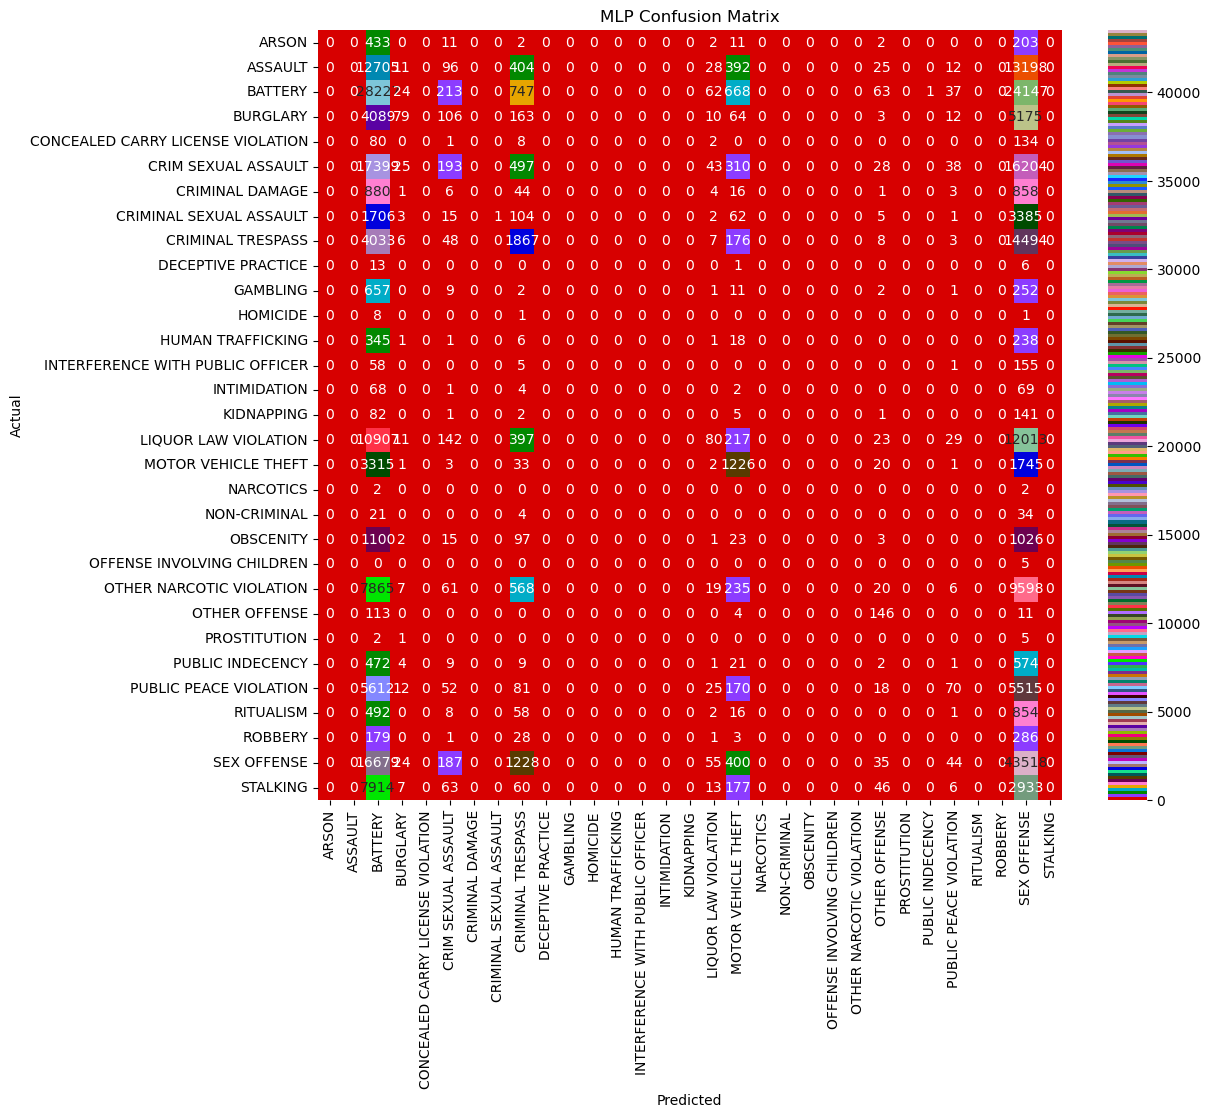

In [10]:
# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose=True)
mlp_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_mlp = mlp_model.predict(X_test)

# Classification report
print("MLP Classification Report:\n")
print(classification_report(y_test, y_pred_mlp, target_names=le.inverse_transform(np.unique(y_test))))

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(12, 10))
# Choose a colorcet colormap
cmap = cc.cm.glasbey_dark

# Plot the heatmap with the colorcet colormap
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap=cmap,
            xticklabels=le.inverse_transform(np.unique(y_test)), 
            yticklabels=le.inverse_transform(np.unique(y_test)))
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()